# Visualise, Correlate, Predict
Author: Ian Coleman <br>
Purpose: Data Science Challenge as below

In [156]:
# ---------------------------------

# The sample data includes following columns:

# * [column 1]: sample names
# * [column 2]: disease status y [1(diseased) & 0(not diseased)]
# * [column 3-12]: 10 features X1,....,X10

# Your tasks are:
# 1) Visualize the data using e.g. R/Python.
# 2) Can you find out which of the 10 features are associated to the disease status y and why?
# 3) Build a model for disease status prediction and evaluate your model.

# ---------------------------------

### Establish Env

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import seaborn as sb
from correlade import correlade # I wrote this --> I'm cool
from scipy import stats
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from pandas_ml import ConfusionMatrix


### Import Data, Overview

In [158]:
df = pd.read_csv('data.tsv', sep='\t')
print('Shape: ', df.shape)
df.sample(2)

Shape:  (100, 12)


,Name,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
47,Sample_48,1,-4.808162,5.312318,3.636051,-3.831866,1.791921,-2.292014,4.089831,1.246265,-0.617850,1.888576
85,Sample_86,0,-3.884838,5.024681,-2.839798,-3.919332,3.787982,-2.469313,4.525671,2.434089,1.122173,2.686804


In [159]:
# 100 observations
# 10 features --> biological samples of unknown background
# Binary outcome --> does or does not have disease

In [160]:
df.describe()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.500000,-5.102348,4.074683,2.113860,-1.272770,1.941356,-2.046476,5.056326,0.148382,-1.149578,2.029137
std,0.502519,2.341112,1.085460,2.793793,2.094911,1.110827,0.533533,1.468583,1.910968,1.832206,0.530362
min,0.000000,-10.098214,1.459342,-5.944515,-6.260319,-0.123066,-3.511152,0.965622,-4.422314,-5.939233,0.230207
25%,0.000000,-6.523894,3.411222,0.095012,-2.338043,1.153160,-2.344421,4.092539,-1.043528,-2.294476,1.705572
50%,0.500000,-5.122969,4.072467,2.180125,-1.222872,1.753379,-2.120063,4.961916,0.231546,-1.155510,2.051032
75%,1.000000,-3.278668,4.842554,4.131111,-0.031634,2.782939,-1.723680,6.280935,1.298053,0.109281,2.422797
max,1.000000,1.307943,6.919229,7.740567,4.562774,4.410060,-0.658039,8.260527,4.549872,3.344339,3.172213


In [161]:
df.dtypes

Name     object
y         int64
X1      float64
X2      float64
X3      float64
X4      float64
X5      float64
X6      float64
X7      float64
X8      float64
X9      float64
X10     float64
dtype: object

In [162]:
df.isna().sum()

Name    0
y       0
X1      0
X2      0
X3      0
X4      0
X5      0
X6      0
X7      0
X8      0
X9      0
X10     0
dtype: int64

In [163]:
# Based on above, no NaN's, now check for outliers

### Visualise

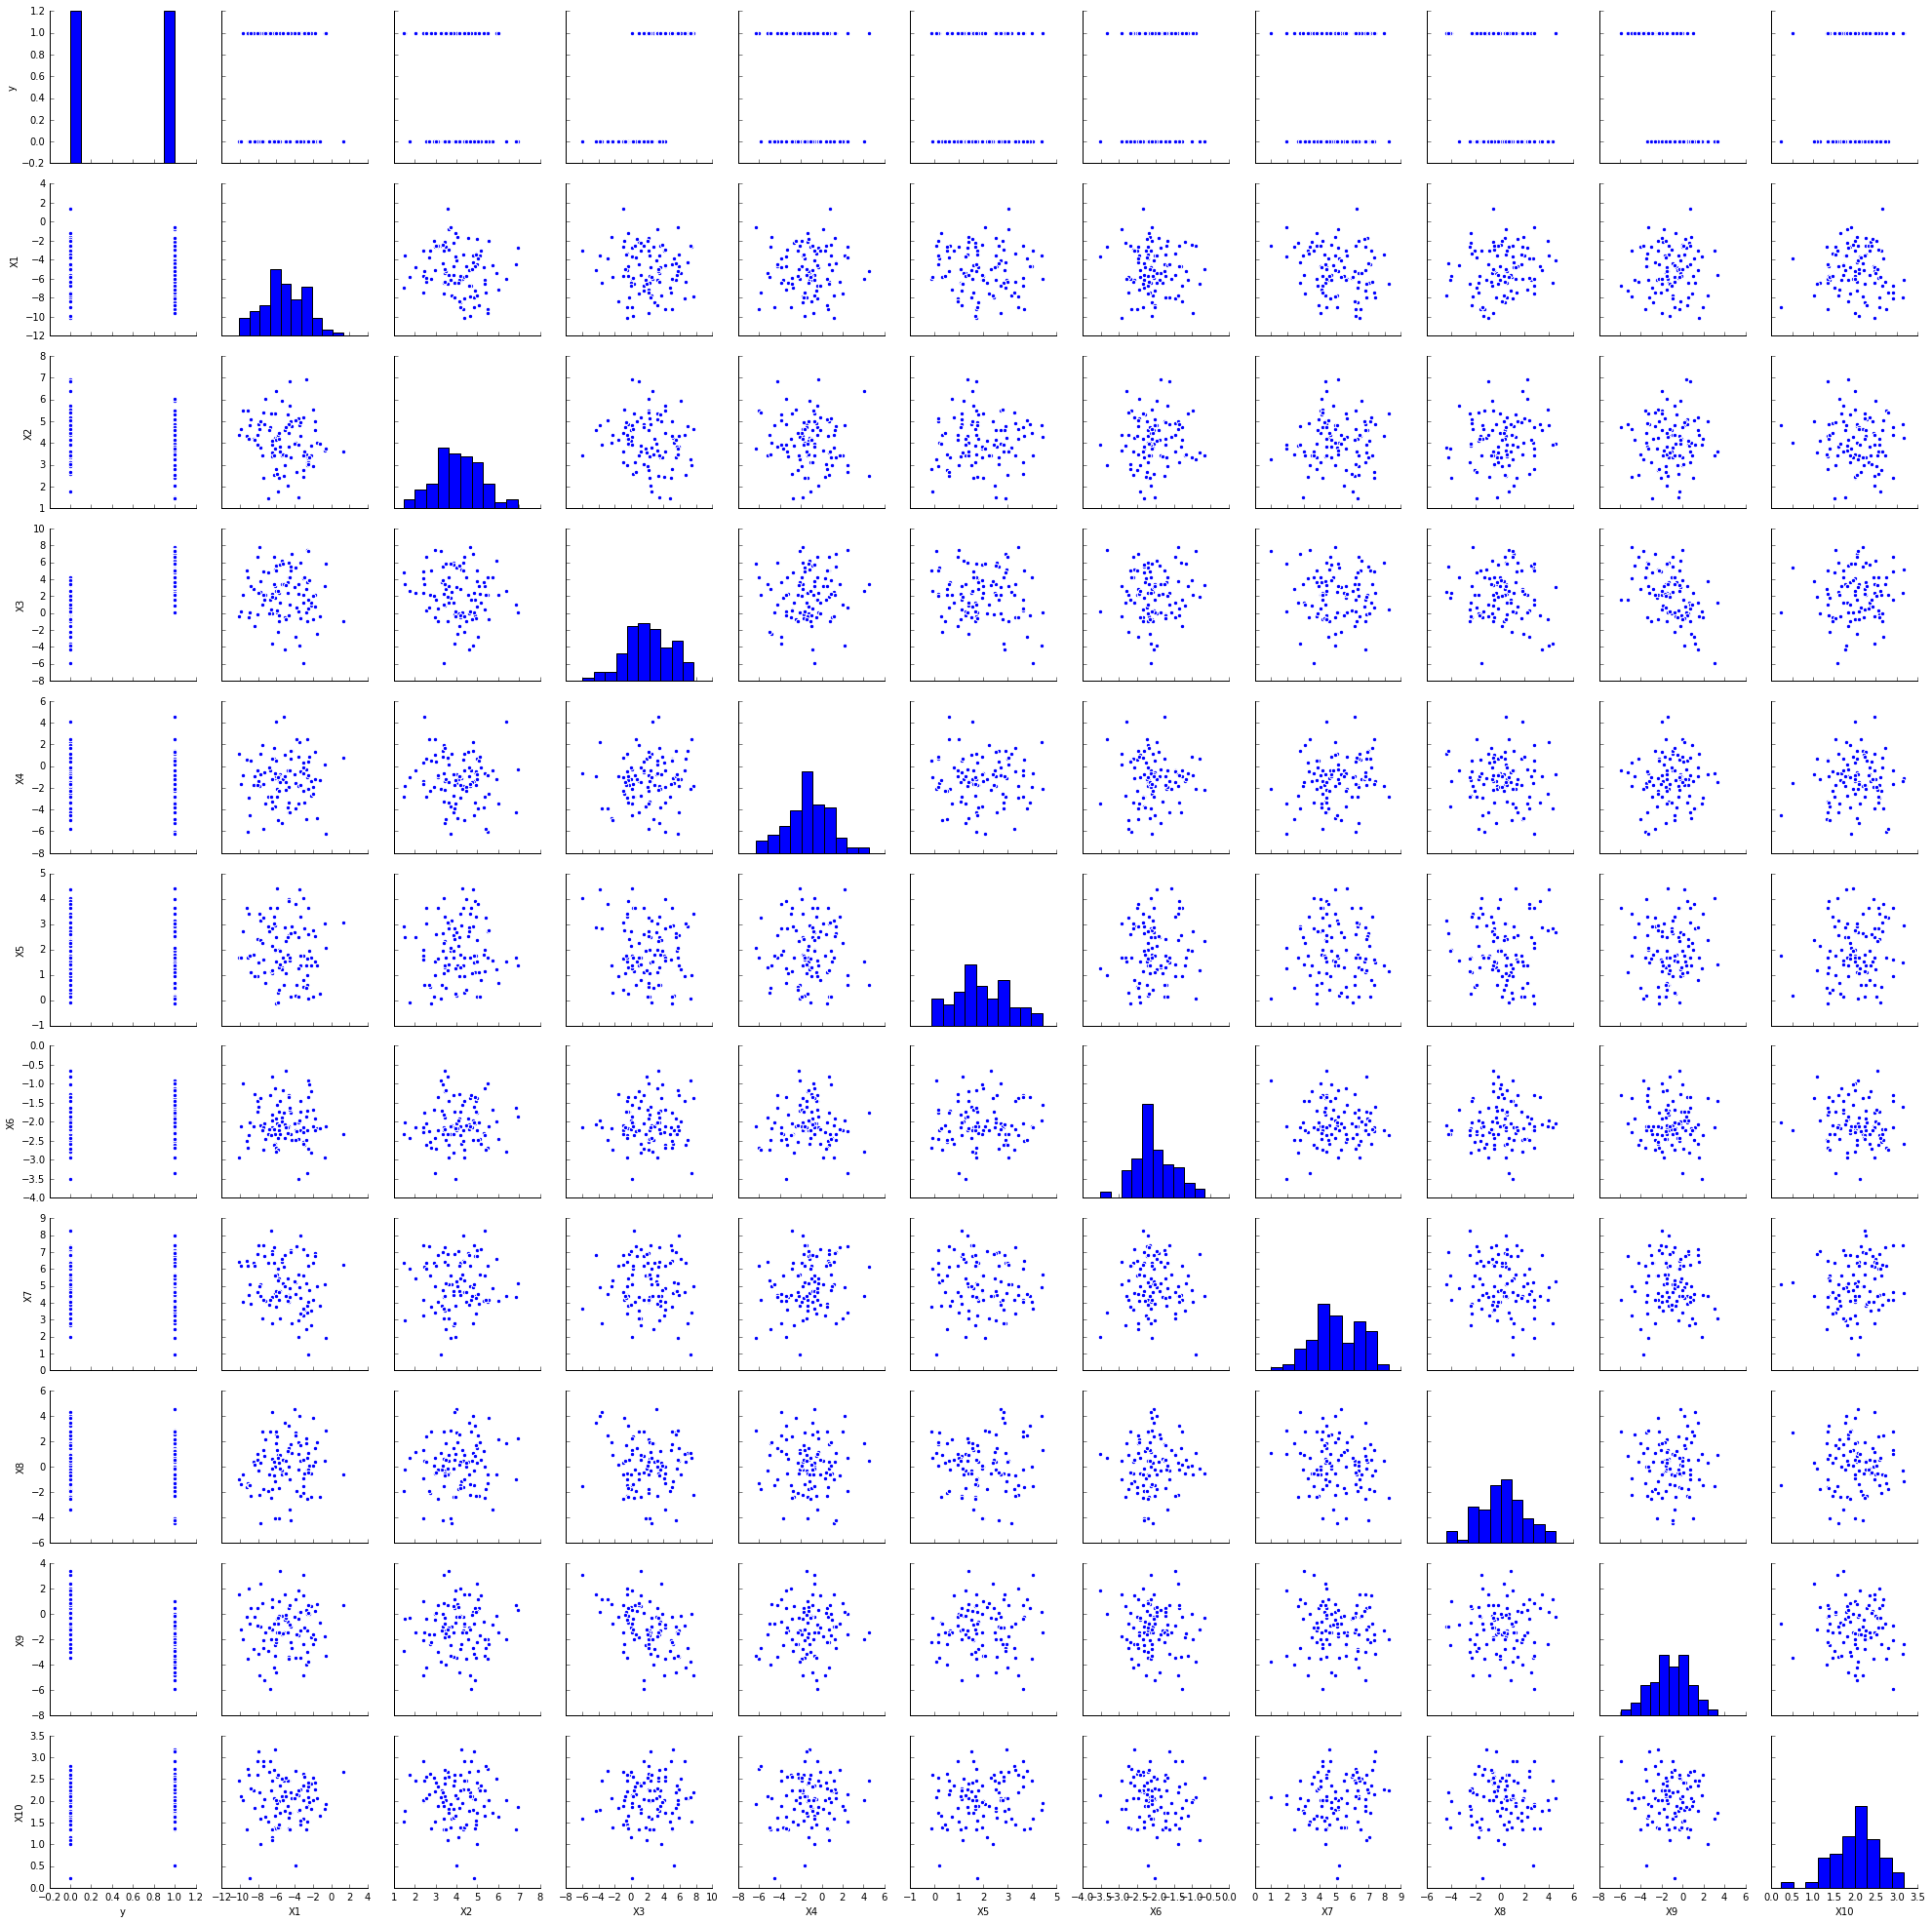

In [164]:
# Pairwise scatterplot --> visually assess for independence of features and for outliers
sb.pairplot(df)
# Conclusion --> couple of potential outliers, will be cautious trimming due to low sample size
# --> features appear to be independent, will run correlation metric though too
# Actually x3 and x9 may have some correlation --> what differentiaties correlation and dependence
# All appear to be within a stone's throw of normal distribution
# 3 and 9 appear to be associated with y, but other feats not so much
# Look at the bottom left hand graph, should I chop out what looks like an outlier?

In [165]:
# Correlation between a continuous and a categorical --> Point biserial correlation
# Assumptions: normally distributed and homoscedastic --> Appear to be met / close enough
for col in df.columns[2:]:
    print('%s with y:' % str(col), stats.pointbiserialr(df[col],df.y))

X1 with y: PointbiserialrResult(correlation=-0.09463380990050332, pvalue=0.34899303399035075)
X2 with y: PointbiserialrResult(correlation=-0.18875216245646695, pvalue=0.06000813348391292)
X3 with y: PointbiserialrResult(correlation=0.7057564812991478, pvalue=2.4147031426668964e-16)
X4 with y: PointbiserialrResult(correlation=-0.020111089759327547, pvalue=0.8425736926867882)
X5 with y: PointbiserialrResult(correlation=-0.023752940476815167, pvalue=0.8145377169405269)
X6 with y: PointbiserialrResult(correlation=0.017760814416105632, pvalue=0.8607739927605074)
X7 with y: PointbiserialrResult(correlation=-0.05629903845249541, pvalue=0.5779690462854645)
X8 with y: PointbiserialrResult(correlation=-0.023076583453902566, pvalue=0.8197279686964312)
X9 with y: PointbiserialrResult(correlation=-0.5749378837367375, pvalue=3.956184353308541e-10)
X10 with y: PointbiserialrResult(correlation=0.07357271628590797, pvalue=0.466941777790702)


In [166]:
# Get pairwise Distance Correlation
correlade.dcorr(df.iloc[:,1:])
# Conclusions: 
# Backs up visual assessment, X3 and X9 are correlated, they correlate more strongly with y than each other
# Other feats have low correlation values

             y         X1         X2         X3         X4         X5  \
y            1 -0.0723118   0.112513    0.71996  -0.123432  -0.110455   
X1  -0.0723118          1   0.216695  -0.100163  -0.145971 -0.0445762   
X2    0.112513   0.216695          1   0.153721  0.0539052 -0.0376689   
X3     0.71996  -0.100163   0.153721          1  -0.058074  0.0453738   
X4   -0.123432  -0.145971  0.0539052  -0.058074          1  -0.114992   
X5   -0.110455 -0.0445762 -0.0376689  0.0453738  -0.114992          1   
X6   -0.121094  -0.112904 -0.0208582 -0.0880566   0.152327 -0.0949486   
X7    -0.11066   0.184528  0.0860942  -0.125171   0.178797 -0.0486006   
X8  -0.0712249    0.14113  0.0217698  0.0999998  -0.112237   0.137759   
X9     0.56236  -0.105375  -0.101425    0.45804 -0.0750649  0.0670981   
X10 -0.0913031   0.101772 -0.0932907  -0.110662 -0.0700965  0.0476891   

            X6         X7         X8         X9        X10  
y    -0.121094   -0.11066 -0.0712249    0.56236 -0.0913031  
X

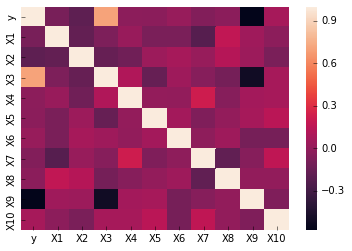

In [167]:
sb.heatmap(df.corr())  
# Purrrty but not appropriate for y (categ)

In [168]:
# Visually assess each for outliers

In [169]:
# Boxplot

### Clean

In [170]:
# Replace outliers with mean value of column - could delete row but observations are limited
# Here an outlier is any value outside of 3 std devs

# Iterate through all X and y cols, replace outliers with mean
for col in df.columns[1:]:
    df[col] = df[np.abs(df[col]-df[col].mean()) <= (3*df[col].std())][col]
    mean = df[col].mean()
    df[col] = df[col].fillna(mean)
    
# Run the scatterplots again after this cell --> I feel like I should chop out what looks like an outlier for X10 
# but I'm not sure I have justification 

### Create Predictive Model


In [171]:
# Choosing model --> We have a binary outcome  --> classification
# Logistic Regression, Tree-based methods, Ensemble,
# We've 10:1 observations to features, meets the rule of thumb but still aim to minimise phantom Degrees of Freedom

In [172]:
%%capture
# ^ this magic means 'no output'
"""Plan:
1. Log Reg x
2. Log reg with chopped preds x
3. Log reg with PCA x
4. Boosted Tree
5. NN
6. Ensemble
This is overkill"""

### Logistic Regresssion 

In [200]:
%%capture
# ^ this magic means 'no output'
# Could chop out X1 and X8 as they have less than 0.1 distance correlation to y
"""Assumptions:
Target variable is binary
Predictive features are interval (continuous) or categorical
Features are independent of one another
Sample size is adequate – Rule of thumb: 50 records per predictor --> Not met! Chop out weaker preds?
"""

In [201]:
df.head()

,Name,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,Sample_1,1,-3.862189,4.005114,5.334341,-1.597156,0.172337,-2.210584,5.217761,2.688107,-3.484756,0.502449
1,Sample_2,1,-4.332433,4.791025,6.994099,1.379125,2.893778,-2.479178,2.783295,1.083796,-2.690662,2.050993
2,Sample_3,1,-5.422645,3.436808,3.450239,-5.217882,1.280875,-1.875442,6.393865,-0.308130,-1.643508,2.103380
3,Sample_4,1,-6.102196,4.213826,5.166152,-1.146564,2.940510,-2.589440,4.567969,-1.164663,-2.404096,3.172213
4,Sample_5,1,-4.483278,4.977083,5.006717,0.726806,0.128842,-1.752203,7.114059,1.773177,-2.254331,1.719560


In [202]:
df.shape

(100, 12)

In [203]:
# X = df[['X2', 'X3', 'X6', 'X7', 'X9', 'X10']].values
X = df.iloc[:,2:].values
y = df.iloc[:,1].values

In [204]:
# # Comment this in for PCA reduction of features to 3 PCs
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(X)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# X = principalDf.values

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [206]:
log_preds = LogReg.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, log_preds)
confusion_matrix

array([[17,  2],
       [ 1, 10]])

In [207]:
print(classification_report(y_test, log_preds))

             precision    recall  f1-score   support

          0       0.94      0.89      0.92        19
          1       0.83      0.91      0.87        11

avg / total       0.90      0.90      0.90        30



In [208]:
%%capture
# ^ this magic means 'no output'
"""Results
1. Log Reg with all feats: 
Conf matrix [[17,  2],[ 1, 10]]
             precision    recall  f1-score   support

          0       0.94      0.89      0.92        19
          1       0.83      0.91      0.87        11

avg / total       0.90      0.90      0.90        30


2. Log Reg with chopped feats
# Chopped Xs 1,4,5,8 based on visual scatter and correlative metrics
conf mat [[15,  4],[ 0, 11]]
precision    recall  f1-score   support

          0       1.00      0.79      0.88        19
          1       0.73      1.00      0.85        11

avg / total       0.90      0.87      0.87        30

3. Log Reg with 3 Principal Components made from all feats
Conf Mat [[16,  3],[ 1, 10]]
             precision    recall  f1-score   support

          0       0.94      0.84      0.89        19
          1       0.77      0.91      0.83        11

avg / total       0.88      0.87      0.87        30

"""

### Boosted Gradient

In [221]:
# Convert into an efficient dmatrix type that I don't understand
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [222]:
# Instantiate model
## TODO tune hyperparameters...also read up on them
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [223]:
# Fit and get predictions
xg_reg.fit(X_train,y_train)

xgb_preds = xg_reg.predict(X_test)
xgb_preds = [round(value) for value in y_pred]

In [224]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.406934


### Evaluation Station

In [225]:
# Get accuracy scores
log_accuracy = accuracy_score(y_test, log_preds)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print("Log Reg accuracy: %.2f%%" % (log_accuracy * 100.0))
print("XGB accuracy: %.2f%%" % (xgb_accuracy * 100.0))

Log Reg accuracy: 90.00%
XGB accuracy: 86.67%


In [226]:
# Get AUC
from sklearn.metrics import roc_auc_score
print('ROC AUC Log Reg: ', roc_auc_score(y_test, log_preds))
print('ROC AUC XGB: ', roc_auc_score(y_test, xgb_preds))

ROC AUC Log Reg:  0.9019138755980862
ROC AUC XGB:  0.8947368421052632


In [ ]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, xgb_preds)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False         15     4       19
True           0    11       11
__all__       15    15       30


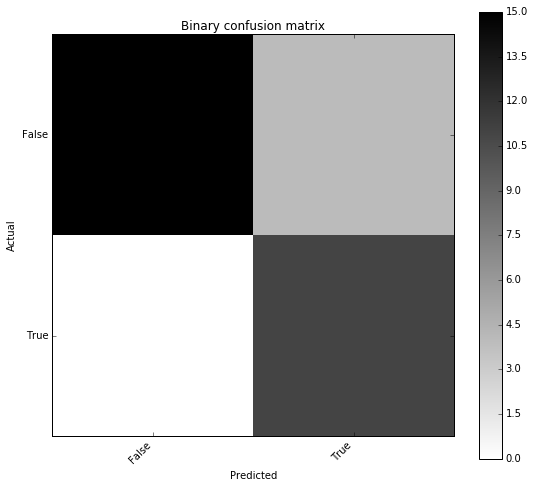

In [229]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, xgb_preds)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()